In [15]:
documents = []

ego_id = '40379006'

file = open('Textos para testes/egos/' + ego_id + '.txt', 'r', encoding='utf-8')
for line in file:
    documents.append(line)
file.close()

file = open('Textos para testes/alters/' + ego_id + '.txt', 'r', encoding='utf-8')
for line in file:
    documents.append(line)
file.close()
print(len(documents))

2719


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features = 1000 # max number of uniq words

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [17]:
from sklearn.decomposition import LatentDirichletAllocation

no_topics = 10
learning_decay = .7
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0,learning_decay = learning_decay).fit(tf)

In [18]:
import numpy as np
import pandas as pd

# Show top n keywords for each topic
def show_topics(vectorizer=tf_vectorizer, lda_model=lda, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=tf_vectorizer, lda_model=lda, n_words=12)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11
Topic 0,time,new,people,talk,live,listen,forget,word,hard,forgive,check,days
Topic 1,god,leaders,goal,know,come,way,mean,need,things,church,change,world
Topic 2,like,make,god,good,life,live,follow,think,happy,feel,start,rt
Topic 3,people,try,want,don,tell,build,pt,tomorrow,power,know,use,tweet
Topic 4,best,retweet,vote,little,matter,curry,story,ladies,hear,ur,music,welcome
Topic 5,love,mind,stand,sin,person,hate,people,year,like,say,god,jesus
Topic 6,watch,wait,believe,umbrella,gonna,eh,30,round,store,hours,1st,step
Topic 7,video,better,help,say,faith,real,lord,psalm,looking,new,room,fear
Topic 8,stay,game,fall,win,play,heart,happen,23,break,leave,alyssa,shall
Topic 9,day,yes,great,sure,today,let,right,tonight,read,ps,join,don


In [19]:
# column names
topicnames = ["Topic" + str(i) for i in range(no_topics)]

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(np.round(lda.components_, 2))

# Assign Column and Index
df_topic_keywords.columns = tf_vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# Vie
#list_frames = []
for t, row in df_topic_keywords.iterrows():
    aux = row.nlargest(12)
    #list_frames.append(aux.to_frame().T)
    print(t)
    a = ''
    for word, weight in aux.items():
        a += ' ' + word + ' (' + str(weight) + ') |'
    print(a)
    print('\n')

#list_frames[1]    

Topic0
 time (84.32) | new (64.03) | people (48.23) | talk (36.12) | live (27.59) | listen (26.96) | forget (23.65) | word (22.78) | hard (21.24) | forgive (16.9) | check (16.44) | days (16.33) |


Topic1
 god (169.63) | leaders (70.6) | goal (66.03) | know (64.67) | come (63.25) | way (46.55) | mean (44.49) | need (41.85) | things (40.77) | church (38.92) | change (35.37) | world (33.7) |


Topic2
 like (90.4) | make (85.53) | god (83.69) | good (78.53) | life (76.65) | live (66.36) | follow (44.15) | think (41.08) | happy (40.83) | feel (39.18) | start (37.14) | rt (34.38) |


Topic3
 people (58.28) | try (36.27) | want (34.81) | don (34.04) | tell (30.64) | build (29.18) | pt (24.59) | tomorrow (24.43) | power (22.14) | know (21.71) | use (21.35) | tweet (18.01) |


Topic4
 best (59.04) | retweet (40.48) | vote (24.73) | little (24.67) | matter (22.02) | curry (21.25) | story (19.98) | ladies (17.48) | hear (16.67) | ur (15.75) | music (15.48) | welcome (15.11) |


Topic5
 love (193

In [20]:
# Create Document - Topic Matrix
lda_output = lda.transform(tf)

# index names
docnames = [str(i) for i in range(len(documents))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 6), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
   color = 'green' if val > .1 else 'black'
   return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
style = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
style

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
0,0.05,0.05,0.05,0.05,0.55,0.05,0.05,0.05,0.05,0.05,4
1,0.014286,0.014286,0.728566,0.014286,0.157143,0.014286,0.014286,0.014286,0.014286,0.01429,2
2,0.009091,0.009091,0.009091,0.009091,0.009093,0.009091,0.009091,0.009091,0.009091,0.91818,9
3,0.899983,0.011117,0.011118,0.011114,0.011111,0.011112,0.011111,0.011111,0.011111,0.011112,0
4,0.014286,0.871425,0.014286,0.014286,0.014286,0.014286,0.014286,0.014289,0.014286,0.014286,1
5,0.025,0.025,0.025,0.025,0.025,0.025,0.52501,0.025,0.27499,0.025,6
6,0.012501,0.012507,0.012507,0.012501,0.0125,0.012502,0.0125,0.887482,0.012501,0.0125,7
7,0.025,0.025,0.025,0.025,0.025,0.025005,0.025,0.025002,0.774993,0.025,8
8,0.01,0.420722,0.010001,0.010003,0.137146,0.010001,0.01,0.01,0.01,0.372127,1
9,0.014286,0.871419,0.014286,0.01429,0.014287,0.014286,0.014286,0.014287,0.014286,0.014287,1


In [21]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,2,472
1,1,469
2,0,362
3,9,341
4,5,227
5,4,194
6,7,190
7,3,177
8,8,166
9,6,121


In [24]:
#Documents of topic that classified most documents (First on the table above)

dominant_topic = df_document_topic['dominant_topic']

topic = df_topic_distribution['Topic Num'][0]

test_text = []
j = 0
for i, doc in enumerate(dominant_topic):
    if doc == 6:
        j+=1
        print('- ' + documents[i] + '  ')
        test_text.append(documents[i])

- AMAZING KEEP WAIT WATCH U WIN 
  
- HE GUARD PATHS PROTECT FAITHFUL PROVERBS 2 8 
  
- LOVE ALWAYS PROTECT ALWAYS TRUST ALWAYS HOP ALWAYS PERSEVERE 1CORINTHIANS 13 7 
  
- WATCH SAN FRANCISCO LEGEND JERRY RICE GO UNDERCOVER LYFT DRIVER 
  
- DO BELIEVE MIRACLES DO BELIEVE GOD HEAL 
  
- LOOOVE COFFEE 
  
- P2P TRANSFORMATION CENTER VIP BARBERSHOP PROUD PRESENT L VE FOR A CAUSE A SPEED DATING EVENT 
  
- DON WAIT PRINCE STEAL HEART MAY GIVE BACK INSTEAD WAIT MAN 
  
- I COULD PROUDER CAN WAIT SEE BIG THINGS 
  
- HI JACK 
  
- I BELIEVE AVAILABLE YOUR ARTISTRY INSPIRE SO DOPE 
  
- JACKGCASSIDY DOIN PROUD YOUR TALENT UNDENIABLE 
  
- CHRISBLUELIVE LIGHT ROOF DOPE WAY KICK THE BETTER WATCH 2 
  
- CONGRATS BATTLE ROUND CAN WAIT SEE NEXT MAN 
  
- THAT ONE BEST BATTLE ROUND I SEE LOOONG TIME CONGRATS 
  
- NOW I TALKIN CAN WAIT SEE TAYLOR TOGETHER 
  
- THE MOST CASUAL STEAL BY 
  
- STEAL ALERT USED HER STEAL 
  
- FUCK 
  
- AVI 2 
  
- AVI 1 
  
- SHOUTOUT APPLE IPHONE 7 
  
- CAN WA

In [9]:
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds='tsne')
panel

/usr/local/lib/python3.5/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
1      17.350004        1       1   -6.421602  -82.439003
2      15.882306        1       2  -33.323769  147.233887
9      12.159441        1       3  -78.574295  -19.436861
0      10.405037        1       4   16.815228    3.135606
5       8.851407        1       5   60.783081  165.098480
3       8.530080        1       6   87.686485  -64.577072
7       8.502010        1       7  -58.664173   64.635735
4       6.967743        1       8   37.553703   79.521461
8       6.347487        1       9  132.937012  102.097099
6       5.004485        1      10  113.036690   18.020233, topic_info=     Category        Freq      Term       Total  loglift  logprob
term                                                             
536   Default  190.000000      love  190.000000  30.0000  30.0000
225   Default   93.000000       day   93.000000  29.0000  29.0000
392   Default  270.000000       god  270.000000  28.0000  28.0000
955   Default   63.000000     watch   63.000000  27.0000  27.0000
903   Default   98.000000      time   98.000000  26.0000  26.0000
99    Default   58.000000      best   58.000000  25.0000  25.0000
622   Default  129.000000    people  129.000000  24.0000  24.0000
518   Default   98.000000      like   98.000000  23.0000  23.0000
579   Default  115.000000       new  115.000000  22.0000  22.0000
994   Default   53.000000       yes   53.000000  21.0000  21.0000
524   Default   85.000000      live   85.000000  20.0000  20.0000
543   Default  108.000000      make  108.000000  19.0000  19.0000
730   Default   40.000000   retweet   40.000000  18.0000  18.0000
394   Default   78.000000      good   78.000000  17.0000  17.0000
505   Default   77.000000   leaders   77.000000  16.0000  16.0000
515   Default  112.000000      life  112.000000  15.0000  15.0000
401   Default   47.000000     great   47.000000  14.0000  14.0000
941   Default   39.000000     video   39.000000  13.0000  13.0000
495   Default   95.000000      know   95.000000  12.0000  12.0000
948   Default   30.000000      wait   30.000000  11.0000  11.0000
101   Default   38.000000    better   38.000000  10.0000  10.0000
833   Default   35.000000      stay   35.000000   9.0000   9.0000
390   Default   72.000000      goal   72.000000   8.0000   8.0000
182   Default   82.000000      come   82.000000   7.0000   7.0000
263   Default   66.000000       don   66.000000   6.0000   6.0000
865   Default   42.000000      sure   42.000000   5.0000   5.0000
922   Default   40.000000       try   40.000000   4.0000   4.0000
907   Default   44.000000     today   44.000000   3.0000   3.0000
432   Default   35.000000      help   35.000000   2.0000   2.0000
94    Default   25.000000   believe   25.000000   1.0000   1.0000
...       ...         ...       ...         ...      ...      ...
268   Topic10    7.412648  download    8.454731   2.8633  -4.3867
84    Topic10    8.012044    battle    9.144834   2.8626  -4.3089
955   Topic10   54.306737     watch   63.154870   2.8439  -2.3952
834   Topic10    6.463594     steal    7.516816   2.8439  -4.5237
291   Topic10    5.499903      ella    6.423793   2.8396  -4.6851
686   Topic10    5.691881   protect    6.664949   2.8370  -4.6508
835   Topic10    8.119010      step    9.515552   2.8361  -4.2957
932   Topic10    5.924579    united    6.965558   2.8330  -4.6108
925   Topic10    5.298599        tv    6.236571   2.8318  -4.7224
919   Topic10    6.031202     trump    7.140510   2.8260  -4.5929
475   Topic10    4.862077      jack    5.839423   2.8117  -4.8084
702   Topic10    4.348316       quo    5.283911   2.8000  -4.9201
146   Topic10    4.191779     cause    5.123958   2.7940  -4.9568
729   Topic10    4.292593    return    5.256558   2.7923  -4.9330
179   Topic10    4.092579    coffee    5.030049   2.7886  -4.9807
266   Topic10    4.031809      dope    4.956183   2.7884  -4.9957
187   Topic10    4.121271  

Text(0.5, 1.0, 'Segregation of Topic Clusters')

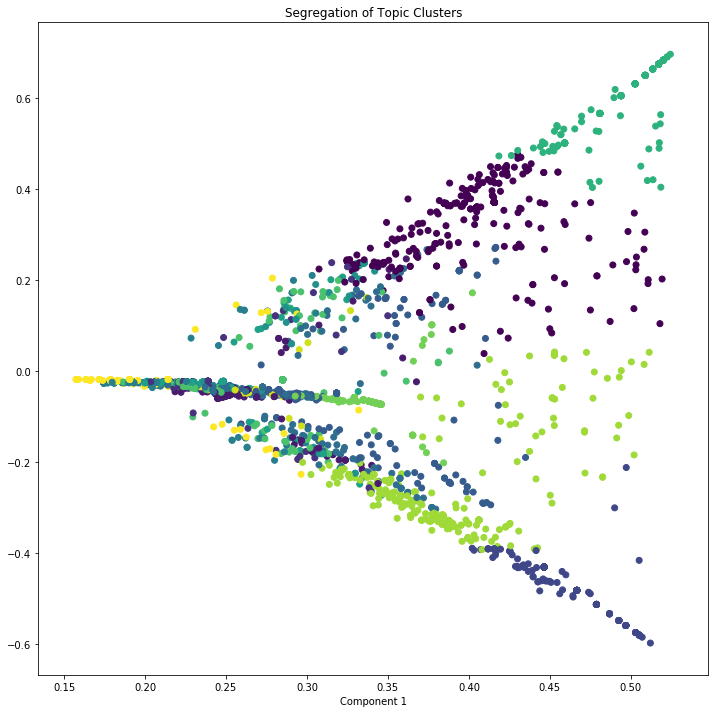

In [10]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
from sklearn.decomposition import TruncatedSVD
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [11]:
#Vectorize transform
text = tf_vectorizer.transform(test_text)

#LDA Transform
topic_probability_scores = lda.transform(text)

for i, doc in enumerate(topic_probability_scores):
    if not np.argmax(doc) == topic:
        print ('Document ' + str(i) + ':')
        print(np.argmax(doc))
        print(test_text[i])
        print(doc)

In [12]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += "  ".join([feature_names[i]
                            for i in topic.argsort()[:-no_top_words - 1:-1]])
        print(message)
    print()

no_top_words = 12
display_topics(lda, tf_feature_names, no_top_words)

Topic #0: time  new  people  talk  live  listen  forget  word  hard  forgive  check  days
Topic #1: god  leaders  goal  know  come  way  mean  need  things  church  change  world
Topic #2: like  make  god  good  life  live  follow  think  happy  feel  start  rt
Topic #3: people  try  want  don  tell  build  pt  tomorrow  power  know  use  tweet
Topic #4: best  retweet  vote  little  matter  curry  story  ladies  hear  ur  music  welcome
Topic #5: love  mind  stand  sin  person  hate  people  year  like  say  god  jesus
Topic #6: watch  wait  believe  umbrella  gonna  eh  30  round  store  hours  1st  step
Topic #7: video  better  help  say  faith  real  lord  psalm  looking  new  room  fear
Topic #8: stay  game  fall  win  play  heart  happen  23  break  leave  alyssa  shall
Topic #9: day  yes  great  sure  today  let  right  tonight  read  ps  join  don



In [13]:
new_documents = []
threshold = .8
for index, row in df_document_topic.iterrows():
    best_topic = row['dominant_topic']
    column = 'Topic'+str(int(best_topic))
    if row[column] >= threshold:
        new_documents.append(documents[int(index)])
        
print(len(new_documents))
documents = new_documents

421
